In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from settings import colors, titles

In [2]:
exp = "10"
base_path = f"/storage/fits/neurocorr/exp{exp}"

In [3]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [4]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [5]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [6]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Observed',
    'Shuffle',
    'Uniform',
    'FA'
]
percentile_groups = [
    'p_s_lfi',
    'p_u_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
lfi_models = [
    'observed',
    'shuffle',
    'uniform',
    'fa'
]
models = [
    'shuffle',
    'uniform',
    'fa'
]
labels2 = [
    'Shuffle',
    'Uniform',
    'FA'
]

In [7]:
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)

with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)

In [25]:
fa_cdf_mse = []
fa_cdf_rank = []
fa_ff_mse = []
fa_ff_rank = []
avg_rank = []
best_obs_p_rank = np.zeros((3, 18, 3))
p_lower = 90
p_upper = 100
obs_percentile_lower = 25
obs_percentile_upper = 75

for result_idx, result in enumerate(results):
    fa_ff_mse.append((opt_fa_ffs[result_idx] - obs_ffs[result_idx])**2)
    fa_ff_rank.append(np.argsort(fa_ff_mse[-1], axis=-1))
    ff_mse_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        fa_max = np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
        equiv_max = np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
        ff_mse_temp[dim_idx] = (fa_max - equiv_max)**2
    fa_cdf_mse.append(ff_mse_temp)
    fa_cdf_rank.append(np.argsort(fa_cdf_mse[-1], axis=-1))
    avg_rank.append(-0.5 * (fa_ff_rank[-1] + fa_cdf_rank[-1]))
    
    # Grab observed percentiles for best avg ranks
    best_obs_p_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_rank[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[p_lower, p_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_obs_p_rank[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

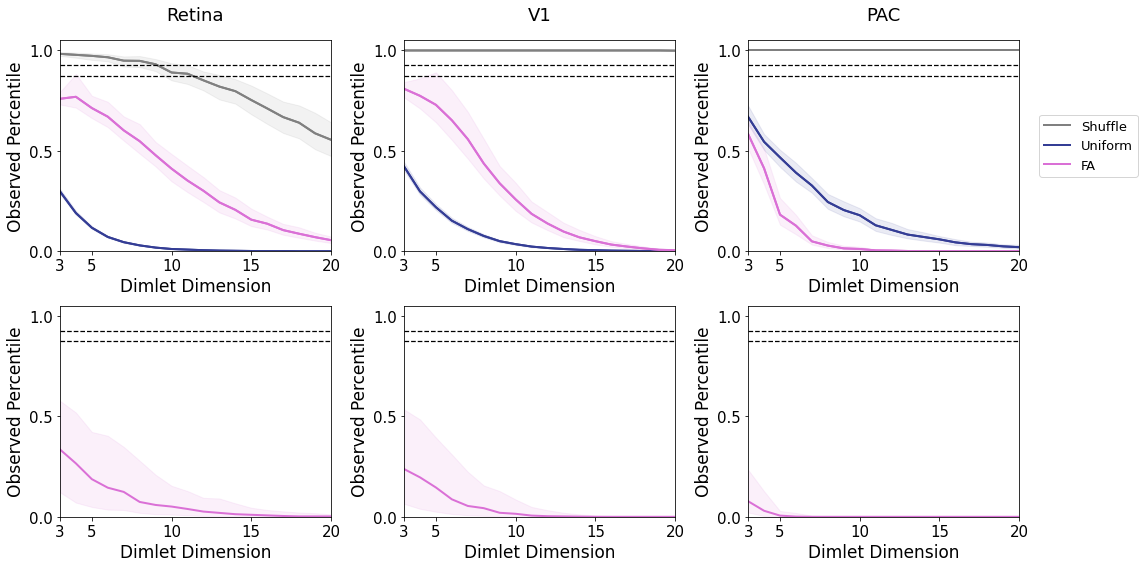

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Label adjustments
subplot_label_size = 22
axis_label_size = 16
title_size = 18
subplot_x = -0.18
subplot_y = 1.12
title_pad = 20
# Line settings
linewidth = 2
line_alpha = 0.8
obs_lw = 2
# Fill settings
fill_alpha = 0.1
# Legend settings
legend_size = 13
handlelength = 0.3
handletextpad = 0.3
# Font sizes
label_font_size = 17
tick_font_size = 15
subplot_label_size = 23
# Percentile bounds for curves
percentile_lower = 40
percentile_upper = 60

# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        percentiles = result[group][:]
        lower_q = 87.5
        upper_q = 92.5
        middle_q = 0.5 * (upper_q + lower_q)
        lower, middle, upper = np.percentile(percentiles, q=[lower_q, middle_q, upper_q], axis=1)

        axes[0, idx].plot(
            dims,
            middle,
            linewidth=linewidth,
            color=colors[model])

        axes[0, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)

        

        lower, upper = np.percentile(avg_rank[idx], q=[lower_q, upper_q], axis=1)
        
        
        axes[0, idx].plot(
            dims,
            middle,
            linewidth=linewidth,
            color=colors[model])

        axes[0, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)
    axes[0, idx].axhline(lower_q / 100, linestyle='--', color='k', lw=1.25)
    axes[0, idx].axhline(upper_q / 100, linestyle='--', color='k', lw=1.25)
        
    # Average rank over dimensions
    axes[1, idx].plot(
        dims,
        best_obs_p_rank[idx, :, 1],
        linewidth=linewidth,
        color=colors[model])

    axes[1, idx].fill_between(
        x=dims,
        y1=best_obs_p_rank[idx, :, 0],
        y2=best_obs_p_rank[idx, :, 2],
        color=colors[model],
        alpha=fill_alpha)
    axes[1, idx].axhline(lower_q / 100, linestyle='--', color='k', lw=1.25)
    axes[1, idx].axhline(upper_q / 100, linestyle='--', color='k', lw=1.25)


for idx, ax in enumerate(axes.ravel()):
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1.05])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_font_size)
    
    ax.set_xlabel('Dimlet Dimension', fontsize=label_font_size)
    ax.set_ylabel('Observed Percentile', fontsize=label_font_size)
    
for idx, ax in enumerate(axes[0]):
    ax.set_title(titles[idx], fontsize=title_size, pad=title_pad)

    
for model, label in zip(models, labels2):
    axes[0, -1].plot([], [], color=colors[model], label=label, linewidth=linewidth)
axes[0, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})
plt.tight_layout()